<a href="https://colab.research.google.com/github/ruddysimon/Predictive-Insurance-Premium-Estimation-with-XGBoost/blob/main/Insurance_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Approach**
- Investigating the Data through Exploratory Data Analysis (EDA)
- Creating and Assessing a Baseline Linear Model
- Examining Linear Regression Assumptions
- Preprocessing the Data for Modeling
- Training the Model
- Evaluating the Model's Performance
- Enhancing the Baseline Linear Model
- Introducing a Non-Linear Model: XGBoost
- Data Preprocessing for XGBoost
- Optimizing Model Training with Sklearn's Pipeline
- Evaluating the Performance of the XGBoost Model
- Comparing the XGBoost Model to the Baseline Linear Model

**Install Packages**

In [1]:
!pip install numpy==1.21.0 --quiet
!pip install pandas==1.5.2 --quiet
!pip install plotly==5.11.0 --quiet
!pip install scikit-learn==1.2.0 --quiet
!pip install scikit-optimize==0.9.0 --quiet
!pip install statsmodels==0.13.5 --quiet
!pip install category_encoders==2.5.1 --quiet
!pip install xgboost==1.7.2 --quiet
!pip install nbformat==5.7.1 --quiet
!pip install matplotlib==3.6.2 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 96.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.21.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 119.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 106.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 59.8 MB/s eta 0:00:00


In [2]:
# Import Dependencies
import pandas as pd
import numpy as np
import plotly.express as px
import sys

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import math
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from sklearn.preprocessing import LabelEncoder
from skopt.space import Real, Categorical, Integer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.feature_selection import RFE

In [3]:
file = pd.read_csv("https://raw.githubusercontent.com/ruddysimon/Predictive-Insurance-Premium-Estimation-with-XGBoost/main/Data/insurance.csv")
display(file)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


We have a dataset with 7 columns and 1338 rows. Let's delve into each column's description individually:


age: The age of the primary beneficiary.

sex: The gender of the primary beneficiary.

bmi: Body Mass Index (BMI) of the primary beneficiary, calculated as $\frac{weight_{kg}}{(height_{metres})^2}$, which represents a person's weight-to-height ratio.

children: The number of dependents or children the primary beneficiary has.

smoker: Indicates if the primary beneficiary is a smoker or not.

region: The geographical region in the US where the primary beneficiary resides.

charges: The individual healthcare expenses billed by the health insurance for the primary beneficiary.

In [4]:
file.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
# Let's check the dataset data types.
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In this dataset, we have three numerical variables (age, BMI, and children) and three categorical variables (sex, smoker, and region). It is important to note that there are no missing values in any of the columns, eliminating the need for imputation during the data preprocessing phase. 

## Split the X and y 

In [6]:
target = 'charges'
X = file.drop(target,axis=1)
y = file[target]

In [7]:
print(X.shape)
print(y.shape)

(1338, 6)
(1338,)


# Checking the Distribution of the Variables

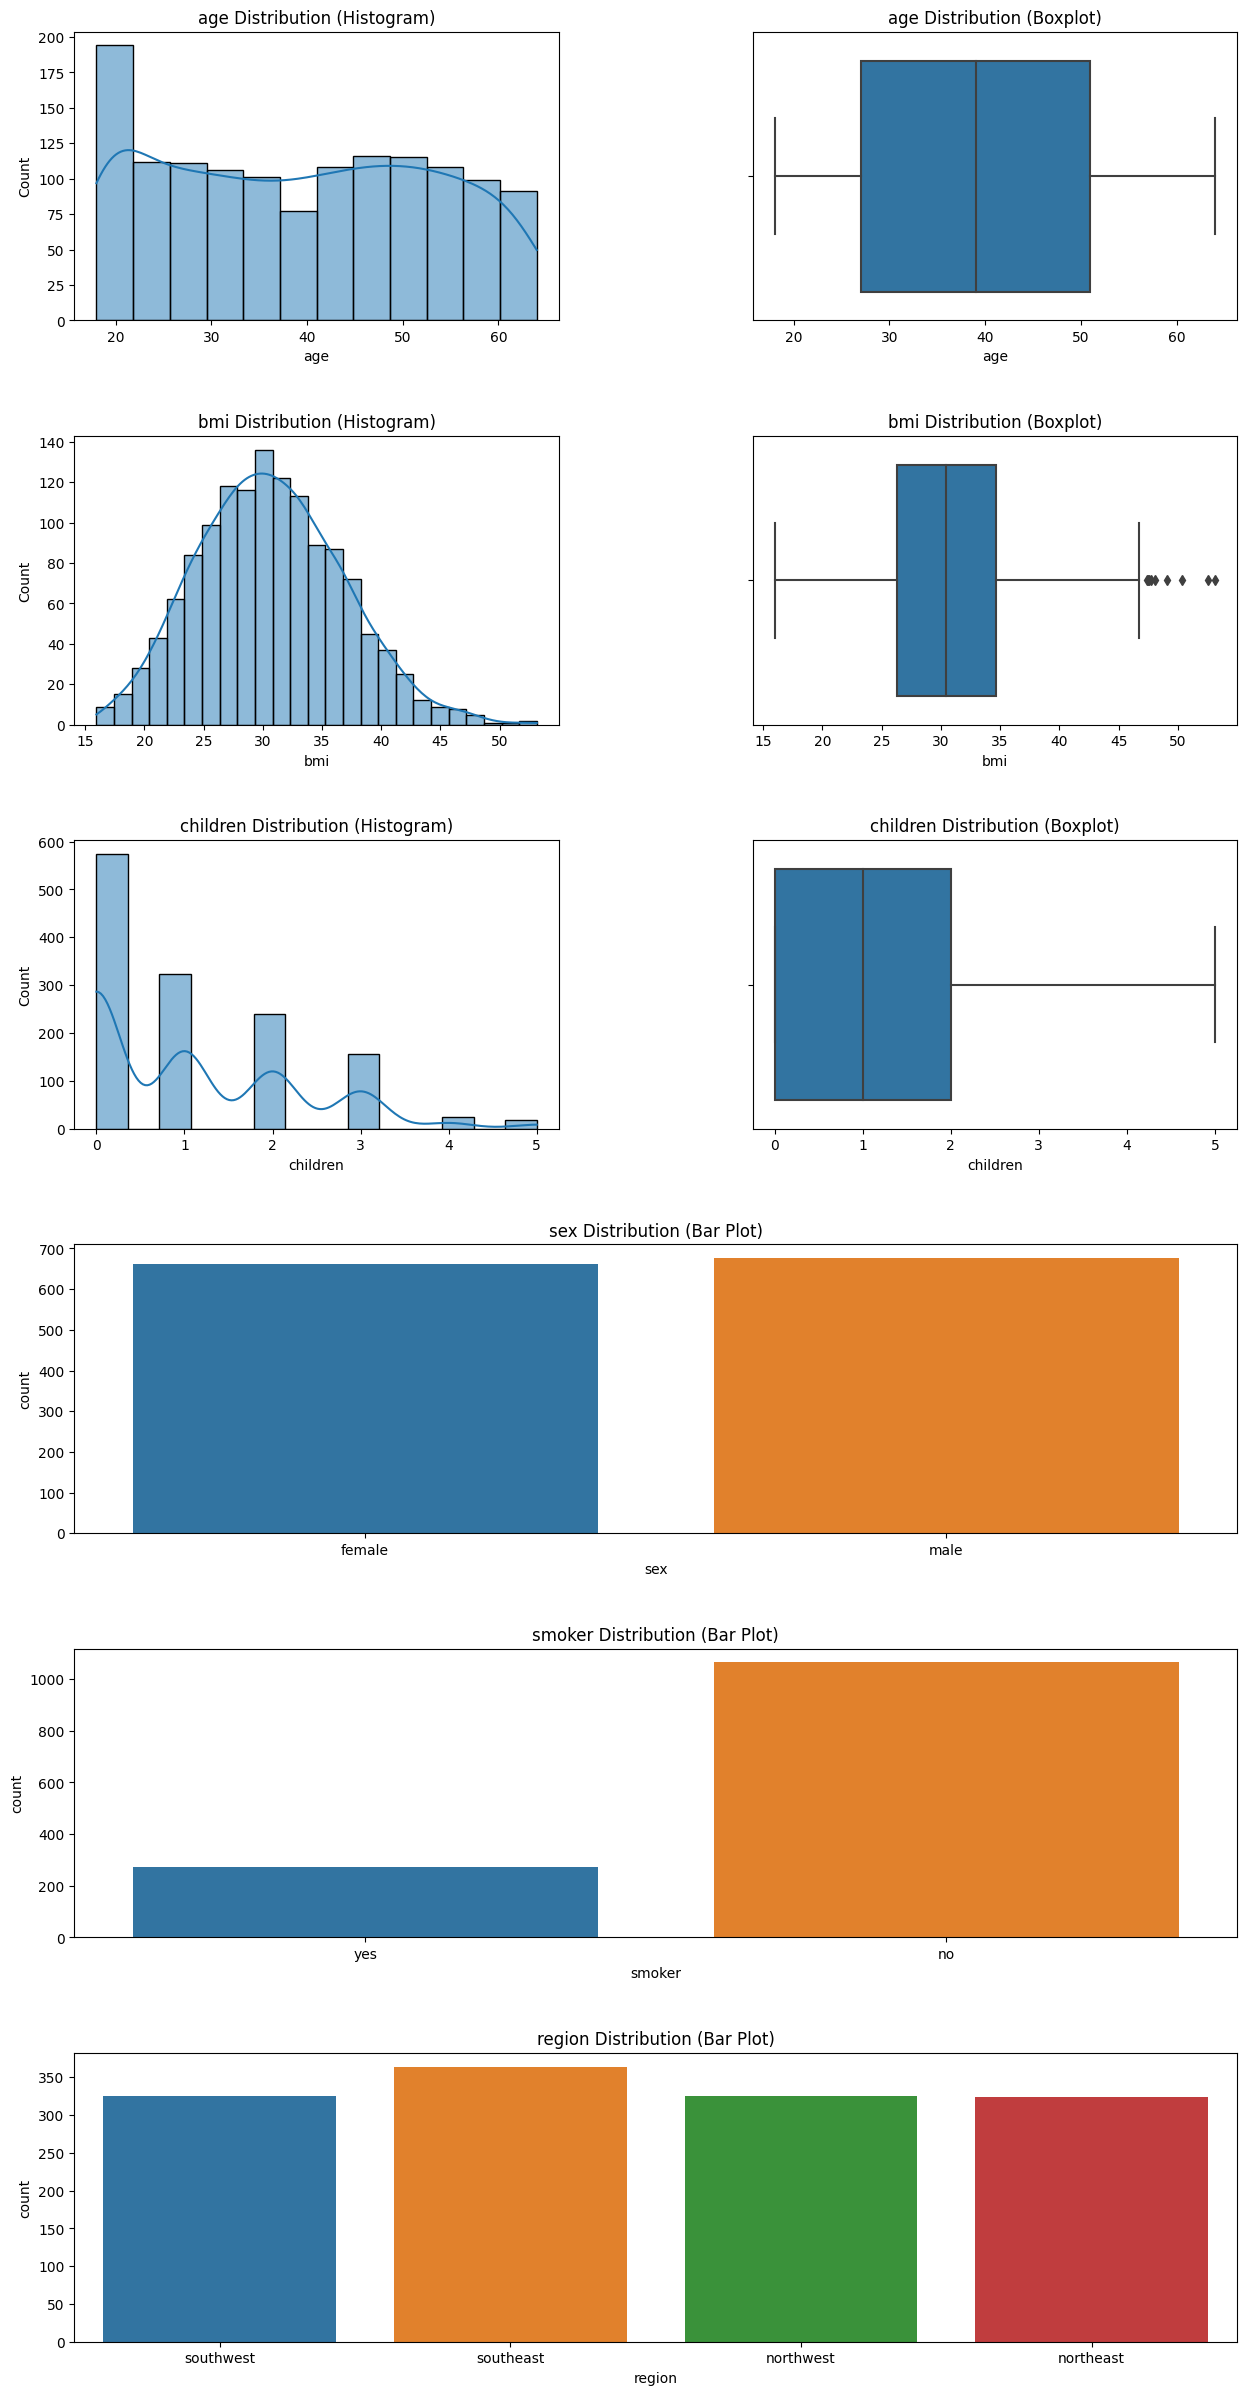

In [8]:
# Function to visualize distributions
def visualize_distributions(data):
    num_cols = data.select_dtypes(include=['number']).columns
    cat_cols = data.select_dtypes(include=['object', 'category']).columns
    total_plots = len(num_cols) + len(cat_cols)
    
    # Set up the figure size and grid
    fig = plt.figure(figsize=(15, total_plots*5))
    grid = plt.GridSpec(nrows=total_plots, ncols=2, figure=fig, wspace=0.4, hspace=0.4)
    
    plot_idx = 0
    for col in num_cols:
        # Histogram
        hist_ax = fig.add_subplot(grid[plot_idx, 0])
        sns.histplot(data=data, x=col, kde=True, ax=hist_ax)
        hist_ax.set_title(f'{col} Distribution (Histogram)')
        
        # Boxplot
        box_ax = fig.add_subplot(grid[plot_idx, 1])
        sns.boxplot(data=data, x=col, ax=box_ax)
        box_ax.set_title(f'{col} Distribution (Boxplot)')
        
        plot_idx += 1
        
    for col in cat_cols:
        # Bar plot
        bar_ax = fig.add_subplot(grid[plot_idx, 0:])
        sns.countplot(data=data, x=col, ax=bar_ax)
        bar_ax.set_title(f'{col} Distribution (Bar Plot)')
        
        plot_idx += 1
        
    plt.show()

# Call the function with your dataset
visualize_distributions(X)

age - Displays a roughly uniform distribution.

sex - Exhibits a nearly balanced proportion between categories.

bmi - Demonstrates an approximately normal distribution.

children - Skewed to the right, with a higher concentration in the lower range.

smoker - Noticeably greater number of observations in the no category compared 
to the yes category.

region - Presents a fairly even distribution across all categories.

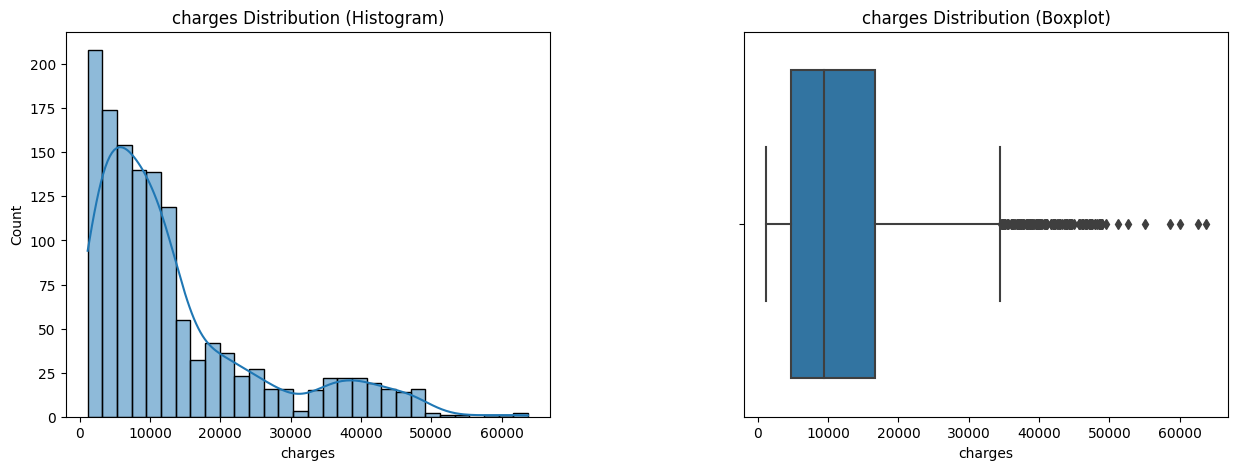

In [9]:
# Since our target variable is a Series, we need to convert it to a DataFrame in order to visualize its distribution
visualize_distributions(pd.DataFrame(y))


So as we can see the distribution is skewed to the right ( low volume in higher range and high volume in lower range)

# Univariate Analysis with Respect to the Target

In [10]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from itertools import combinations, product


def plot_univariate_numeric(X, y):
    fig = make_subplots(rows=X.shape[1], cols=1)
    for i, col in enumerate(X.columns):
        fig.add_trace(
            go.Scatter(
                x=X[col],
                y=y,
                name=col,
                mode='markers'
            ),
            row=i+1,
            col=1
        )
        fig.update_xaxes(
            title_text=col,
            row=i+1,
            col=1
        )
        fig.update_yaxes(
            title_text='charges',
            row=i+1,
            col=1
        )
    fig.update_layout(
        height=1200
    )
    fig.show()

In [11]:
plot_univariate_numeric(
    X.select_dtypes(include=np.number), 
    y
)

age - With increasing age, charges tend to rise as well (although there is significant variability in charges for any given age).

bmi - There is no evident relationship; however, a cluster of individuals with bmi > 30 and charges > 30k seems to be present. This group may become more visible when we conduct our bivariate analysis later.

children - There is no apparent relationship (although charges appear to decrease as the number of children increases). Since this feature has only six unique values, we can consider treating it as a categorical variable for univariate analysis purposes.

In [12]:
def plot_univariate_categorical(X, y):
    fig = make_subplots(rows=X.shape[1], cols=1)
    for i, col in enumerate(X.columns):
        fig.add_trace(
            go.Box(
                x=X[col],
                y=y,
                name=col,
            ),
            row=i+1,
            col=1
        )
        fig.update_xaxes(
            title_text=col,
            row=i+1,
            col=1
        )
        fig.update_yaxes(
            title_text='charges',
            row=i+1,
            col=1
        )
    fig.update_layout(height=1200)
    fig.show()

In [13]:
plot_univariate_categorical(
    X[['sex', 'smoker', 'region', 'children']], 
    y
)

sex - There are no notable differences in charges between the categories.

smoker - Charges for individuals with smoker == 'yes' are generally much higher than those with smoker == 'no'.

region - No substantial differences in charges are observed among the categories.

children - No significant differences in charges exist between the categories (although charges for children >= 4 lean towards lower amounts, this is likely attributable to the low volume in those categories, as seen in the Distributions section).

# Bivariate Analysis with Respect to the Target

In [14]:
# Categorical variables
def plot_paired_boxplots(X, y):
    col_pairs = list(combinations(X.columns, 2))
    fig = make_subplots(rows=len(col_pairs), cols=1)
    for i, (col1, col2) in enumerate(col_pairs):
        paired_cat = col1 + '=' + X[col1] + ', ' + col2 + '=' + X[col2]
        fig.add_trace(
            go.Box(
                x=paired_cat,
                y=y,
                name=f'{col1} & {col2}'
            ),
            row=i+1,
            col=1
        )
        fig.update_xaxes(
            title_text=f'{col1} & {col2}',
            row=i+1,
            col=1,
            categoryorder='array',
            categoryarray=sorted(paired_cat.unique())
        )
        fig.update_yaxes(
            title_text='charges',
            row=i+1,
            col=1
        )
    fig.update_layout(
        height=1800
    )
    fig.show()

In [15]:
plot_paired_boxplots(
    X[['sex', 'smoker', 'region']], 
    y
)

*sex-smoker* - The median charges for male smokers are higher compared to female smokers (36k vs 29k).

*smoker-region* - The median charges for smokers in the southwest and southeast are higher compared to those in the northeast and northwest (35k and 37k vs 28k and 27k).

In [16]:
# Numeric and categorical variables
def plot_paired_scatterplots(X, y):
    data = pd.concat([X, y], axis=1)
    num_cols = X.select_dtypes(np.number).columns
    cat_cols = X.select_dtypes(object).columns
    col_pairs = list(product(num_cols, cat_cols))
    fig = make_subplots(rows=len(col_pairs), cols=1)
    j = 1
    for i, (col1, col2) in enumerate(col_pairs):
        for col2_val in X[col2].unique():
            mask = X[col2] == col2_val
            X_ = X[mask]
            y_ = y[mask]
            fig.add_trace(
                go.Scatter(
                    # data_frame=data,
                    x=X_[col1],
                    y=y_,
                    # marker_color=X_[col2],
                    name=col2_val,
                    mode='markers',
                    legendgroup=j
                ),
                row=i+1,
                col=1
            )
        fig.update_xaxes(title_text=col1, row=i+1, col=1)
        fig.update_yaxes(title_text=y.name, row=i+1, col=1)
        j += 1
    fig.update_layout(
        height=4800,
        legend_tracegroupgap=485,
    )
    fig.show()

In [17]:
plot_paired_scatterplots(X, y)

*age-smoker* - A group can be identified in the bottom-left quadrant of the chart (where age < 50 and smoker = 'no'), in which all beneficiaries have healthcare costs below 10k, a relatively small amount compared to the rest of the population.

*bmi-smoker* - In the top-right quadrant of the chart (where bmi > 30 and smoker = 'yes'), a group of beneficiaries can be observed with healthcare costs above 30k, which is considerably high compared to the rest of the population.

# Check Collinearity

Now let's examine the collinearity (correlation) between features.

The approach we take to analyze this depends on the nature of the feature pairs—whether they are all numeric, all categorical, or a combination of both. For all numeric pairs, we'll employ Pearson's correlation; for all categorical pairs, we'll use a chi-squared (𝜒²) test; and for categorical-numeric pairs, we'll perform an Analysis of Variance (ANOVA) test.

### Numeric features


In [18]:
px.imshow(X.select_dtypes(include=np.number).corr())

This correlation shows there is a very little correlation between numeric variables - the highest one is 0.11

### Categorical features

**Chi-Squared Test**

Frequently, we need to compare the distribution of a categorical variable in a sample to the distribution of a categorical variable in another sample.

The chi-squared test of independence, also known as the chi-squared test of association, is used to determine whether categorical variables are related.

The data must meet the following requirements for this test:

Categorical variables
Relatively large sample size
Independent observations
The chi-squared test is performed using the following steps:

Calculate the "expected" number (E) for each observed number (O) in the table.
Compute the chi-square statistic: χ2 = ∑(𝑂𝑖–𝐸𝑖)²/𝐸𝑖

A chi-square test provides us with a p-value. The p-value indicates whether our test results are significant. To perform a chi-square test and calculate the p-value, we need two pieces of information:

Degrees of freedom, which is simply the number of categories minus one.
Significance level. The standard alpha level is 0.05 (5%), but alternative values such as 0.01 or 0.10 are possible.
The different p-values indicate different hypothesis interpretations:

P <= 0.05; Reject the hypothesis
P > 0.05; Accept the hypothesis

In [19]:
import scipy.stats as stats

def chi2(X, correction=True):
    col_pairs = list(combinations(X.columns, 2))
    results_list = []
    for col1, col2 in col_pairs:
        contingency = pd.crosstab(
            X[col1],
            X[col2]
        )
        chi2, p_val, dof, exp_freq = stats.chi2_contingency(
            contingency.values, correction=correction
        )
        results_list.append([col1, col2, chi2, p_val, dof])
    results = pd.DataFrame(
        results_list,
        columns=[
            'column1', 'column2', 'chi_squared', 'p_value', 'dof'
        ]
    )
    return results

In [20]:
X_chi = chi2(X.select_dtypes(object))
X_chi

,column1,column2,chi_squared,p_value,dof
0,sex,smoker,7.392911,0.006548,1
1,sex,region,0.435137,0.932892,3
2,smoker,region,7.343478,0.061720,3


We can use the p-value (derived from the 𝜒² result and the degrees of freedom) to test the likelihood of the observed distribution (for each feature pair) occurring by chance. For instance, a p-value of 0.5 implies a 50% probability of observing the distribution purely by chance.

A threshold of < 0.05 is widely accepted for rejecting the null hypothesis (that the features are independent), as this signifies that there is only a 5% probability of observing the distribution by chance.

The only feature pair with a p-value less than this threshold is sex and smoker, suggesting that these features are likely correlated:

In [21]:
X_chi[X_chi['p_value'] < 0.05]

,column1,column2,chi_squared,p_value,dof
0,sex,smoker,7.392911,0.006548,1


# Numeric-categorical features

For numeric-categorical feature pairs, we'll use an ANOVA test. ANOVA stands for Analysis of Variance - it helps us understand if there are statistically significant differences between the means of independent groups.

ANOVA is an abbreviation for Analysis of Variances, which evaluates the differences between group means. It's a statistical hypothesis test that examines whether the means of at least two populations differ. To run ANOVA, we need at least one continuous variable and one categorical variable that divides the data into comparison groups. The term "analysis of variances" refers to how the test uses variances to determine if the means are different.

ANOVA compares the variance of group means to the variance within the groups. This method determines if the groups are part of a larger population or if they are distinct populations with different means.

Although it analyzes variances, ANOVA tests means. One-way ANOVA is the most basic type of ANOVA. This method is a generalization of t-tests that can be used to compare more than two groups.

The null hypothesis is that all groups have the same mean, and the alternative hypothesis is that at least one group has a different mean.

In [22]:
def anova(X):
    num_cols = X.select_dtypes(np.number).columns
    cat_cols = X.select_dtypes(object).columns
    col_pairs = list(product(num_cols, cat_cols))
    results_list = []
    for num_col, cat_col in col_pairs:
        X_filtered_list = []
        cat_values = X[cat_col].unique()
        for cat_value in cat_values:
            X_filtered_list.append(X[X[cat_col] == cat_value][num_col].values)
        f_stat, p_val = stats.f_oneway(*X_filtered_list)
        results_list.append([num_col, cat_col, f_stat, p_val])
    results = pd.DataFrame(
        results_list,
        columns=[
            'num_column', 'cat_column', 'f_stat', 'p_value'
        ]
    )
    return results

In [23]:
X_anova = anova(X)
X_anova

,num_column,cat_column,f_stat,p_value
0,age,sex,0.581369,4.459107e-01
1,age,smoker,0.836777,3.604853e-01
2,age,region,0.079782,9.709891e-01
3,bmi,sex,2.878970,8.997637e-02
4,bmi,smoker,0.018792,8.909850e-01
5,bmi,region,39.495057,1.881839e-24
6,children,sex,0.393659,5.304898e-01
7,children,smoker,0.078664,7.791596e-01
8,children,region,0.717493,5.415543e-01


In [24]:
X_anova[X_anova['p_value'] < 0.05]

,num_column,cat_column,f_stat,p_value
5,bmi,region,39.495057,1.881839e-24


The only feature pair with a p-value less than this threshold is `bmi` and `region`, which means it's likely that these features are correlated:

# Build and Evaluate a Baseline (Linear Model)

### Simple Linear Regression Model (Multiple Linear Regression)

Linear regression, also known as simple regression, establishes a relationship between two variables. Visually represented by a straight line, linear regression shows how a change in one variable impacts a change in the other. The y-intercept of a linear regression relationship indicates the value of one variable when the other variable is 0.

Multiple linear regression models the association between multiple independent variables and a single dependent variable.

𝑦̂ = 𝛽0 + 𝛽1𝑥1 + … + 𝛽𝑝𝑥𝑝 + 𝜖

where 𝑝 is the number of features in the model.

For any given independent variable (x) value, y is the estimated value of the dependent variable (y).

𝛽0 represents the intercept, or the predicted value of y, when x is 0. 

𝛽1 is the regression coefficient of variable 𝑥1, which informs us about the change in y as 𝑥1 increases or decreases. 

𝛽𝑝 is the regression coefficient of the final variable 𝑥𝑝, indicating the change in y as 𝑥𝑝 increases or decreases. 𝑥1 ... 𝑥𝑝 are the independent or predictor variables that assist in predicting y. 

𝜖 represents the error due to inaccuracies in calculating the regression coefficients.

### Asumptions for a linear regression model include:

1- **Independence of observations**: Individual observations are not related to one another.

2- **Linearity**: A linear relationship exists between the target and features.

3- **Independence**: Minimal or no collinearity is present between features.

4- **Normality of residuals**: The residuals follow a normal distribution.

5- **Homoscedasticity**: The residuals exhibit consistent variance across target values.

Keep in mind that:

Assumption 1 holds true for this dataset since the healthcare cost charge for one beneficiary should not be associated with another.

Assumptions 2-3 will guide our data processing approach.

Assumptions 4-5 will help us evaluate whether our linear model is appropriate for the task.

### Errors in Regression

The regression line aims to create the best fit by minimizing errors, which means that it tries to make the residuals as small as possible. In the plot, we can observe that the regression line doesn't perfectly predict the true values, indicating that there will always be some room for errors.

Let's discuss the various error metrics in Regression:

Mean Absolute Error (MAE): MAE is a simple regression error metric to understand. It calculates the residual for each data point individually, taking the absolute value of each so that negative and positive residuals don't negate each other. The average of these residuals represents the MAE, which essentially describes the average magnitude of the residuals.

Mean Squared Error (MSE): MSE is similar to MAE but squares the differences before averaging them. MSE is almost always larger than MAE due to squaring the differences. Consequently, we cannot directly compare MAE and MSE but can only compare the error metrics of one model with another. Outliers in the data significantly impact the squared term in the MSE equation. In contrast to MAE, where each residual contributes proportionally to the overall error, the error increases quadratically in MSE. Therefore, outliers in the data will contribute much more to the total error in MSE than in MAE.

 
Root Mean Squared Error (RMSE): RMSE is another error metric you might encounter. As the name suggests, it is the square root of the MSE. Since MSE is squared, its units are different from the original output. RMSE is often used to convert the error metric back to comparable units, making interpretation more straightforward. Outliers have a similar impact on both MSE and RMSE, as they both square the residual.

Mean Absolute Percentage Error (MAPE): MAPE is the percentage equivalent of MAE. It represents the average proportion of error generated by the model, much like MAE reflects the average magnitude of error. MAPE is more easily interpreted because percentages are more intuitive to understand. Due to the use of absolute values, both MAPE and MAE are resilient to the effects of outliers.

In summary, these error metrics can be used to assess the performance of regression models, and the choice between them depends on the specific needs of your application and how errors should be treated.

### Model Comparisions

The coefficient of determination, R², is the proportion of the variance in the dependent variable that is explained by the independent variable(s). R² is expressed between 0 and 1, indicating the level of variance explained. We know that a robust model should have a low SSE/TS ratio, representing the unexplained variance by the independent variable(s). 

Adjusted R² is a corrected goodness-of-fit statistic for linear models. It measures the proportion of variance in the target variable explained by the input or inputs. R² tends to overestimate the goodness-of-fit of the linear regression, as it always grows with the number of independent variables in the model. This occurs because we tend to subtract a large amount (due to multiple variables) when calculating the error as the number of independent variables increases. Consequently, the SSE/TS ratio is even lower than it should be, and R² appears to be high even though the model might not be suitable for production data. Adjusted R² accounts for this overestimation.

In summary, adjusted R² provides a more accurate measure of the goodness-of-fit in linear regression models, particularly when multiple independent variables are involved. This helps to prevent overestimation and ensures that the model is appropriate for real-world data.​	
 

# Split Train and Test (linear-model)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Removing unncessary columns

After conducting Exploratory Data Analysis (EDA), it has been determined that the 'children' feature is not strongly correlated with 'charges', which violates linearity of a linear regression model (each independent variable should have a linear relationship with the dependent variable). As a result, it's recommended to remove this feature from the training set.

Furthermore, the 𝜒² test revealed a correlation between the 'sex' and 'smoker' features, while the ANOVA test suggested a correlation between the 'region' and 'bmi' features. This violates Assumption 3 of a linear regression model (no multicollinearity among independent variables). To address this issue, it's advised to remove the 'sex' and 'region' features from the training set, as they demonstrated weaker predictive power concerning the target variable.

By removing these features from the training set, the linear regression model will better adhere to its assumptions, potentially leading to improved prediction accuracy and model performance.

In [26]:
drop_cols = ["children", "sex", "region"]

X_train.drop(drop_cols,axis=1, inplace=True)
X_test.drop(drop_cols, axis=1, inplace=True)

In [27]:
# Encoding the `smoker` variable since it stored as `yes` and `no`

encoder = LabelEncoder()
X_train["smoker"] = encoder.fit_transform(X_train["smoker"])
X_test["smoker"] = encoder.fit_transform(X_test["smoker"])

In [28]:
display(X_train)

,age,bmi,smoker
1046,43,25.080,0
682,39,35.300,1
1037,45,30.495,1
490,19,32.900,0
39,60,39.900,1
...,...,...,...
1095,18,31.350,0
1130,39,23.870,0
1294,58,25.175,0
860,37,47.600,1


### Balancing the target variable

In [29]:
pt = PowerTransformer(method='yeo-johnson')
y_train_t = pt.fit_transform(y_train.values.reshape(-1, 1))[:, 0]
y_test_t = pt.transform(y_test.values.reshape(-1, 1))[:, 0]

<Axes: >

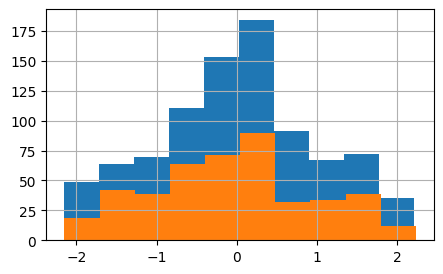

In [30]:
pd.Series(y_train_t).hist(figsize=(5, 3))
pd.Series(y_test_t).hist(figsize=(5, 3))

Using sample weights can help improve the homoscedasticity (assumption of equal or similar variances in different groups being compared) of the residuals by assigning different importance to the observations based on their charges. In this case, we'll give more importance to observations with larger charges and penalize residuals more heavily for those observations compared to ones with smaller charges.



In [31]:
min_charge = np.min(y_train)
sample_weights = y_train / min_charge

In [32]:
lr = LinearRegression()

lr.fit(X_train, y_train_t, sample_weight = sample_weights )

LinearRegression()

In [33]:
# Model Evaluation
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

Keep in mind that the model was trained using a transformed version of the target variable. As a result, it's necessary to apply the inverse `Yeo-Johnson` transformation to convert the model's predictions back to the original format of the target variable.

In [34]:
y_pred_train = pt.inverse_transform(y_pred_train.reshape(-1, 1))[:, 0]
y_pred_test = pt.inverse_transform(y_pred_test.reshape(-1, 1))[:, 0]

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def calc_model_performance(y_true, y_pred):
    results = {}
    results['Root Mean Squared Error'] = mean_squared_error(
        y_true, y_pred, squared=False
    )
    results['Mean Squared Error'] = mean_squared_error(y_true, y_pred)
    results['Mean Absolute Error'] = mean_absolute_error(y_true, y_pred)
    results['Mean Absolute Percentage Error'] = mean_absolute_percentage_error(
        y_true, y_pred
    )
    results['R Squared'] = r2_score(y_true, y_pred)
    return results


In [60]:
base_train_performance = calc_model_performance(y_train, y_pred_train)
base_train_performance

{'Root Mean Squared Error': 5964.0300795252915,
 'Mean Squared Error': 35569654.78948246,
 'Mean Absolute Error': 4583.192074027689,
 'Mean Absolute Percentage Error': 0.7487184929524596,
 'R Squared': 0.7572131565075645}

In [62]:
base_test_performance = calc_model_performance(y_test, y_pred_test)
base_test_performance

{'Root Mean Squared Error': 5752.477398059848,
 'Mean Squared Error': 33090996.215189405,
 'Mean Absolute Error': 4534.422635060566,
 'Mean Absolute Percentage Error': 0.7565371511851344,
 'R Squared': 0.7741917232715532}

### Check normality of residuals

We can check the normality of residuals using a QQ (quantile-quantile) plot. This plots the value of each actual quantile (from the data) vs the theoretical quantile (assuming a normal distribution). If the data is perfectly normally distributed, you'd expect the datapoints to lie on the line.



In [38]:
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

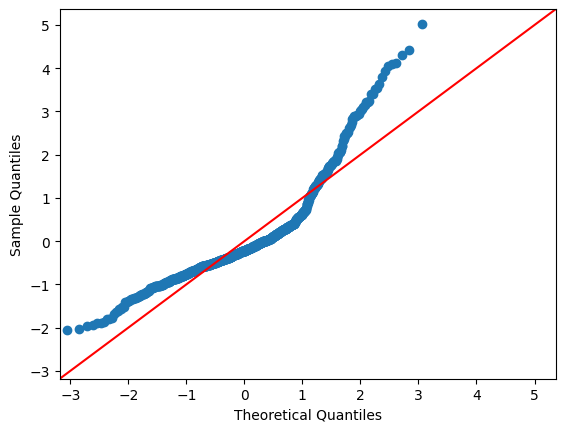

In [39]:
fig = sm.qqplot(
    residuals_train, 
    fit=True, 
    line='45'
)

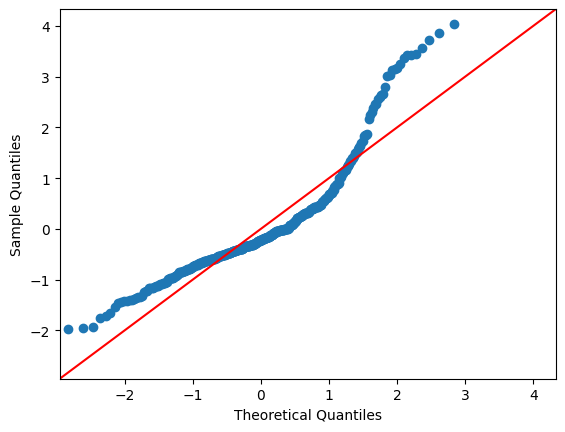

In [40]:
fig = sm.qqplot(
    residuals_test, 
    fit=True, 
    line='45'
)

### Examining Homoscedasticity

To assess homoscedasticity, we can use a scatterplot with the target variable plotted along the x-axis and the residuals plotted along the y-axis. Ideally, the data points should be evenly distributed across the y-axis as the x-value (i.e., the target value) increases:

In [41]:
px.scatter(x=y_train, y=residuals_train)

In [42]:
px.scatter(x=y_test, y=residuals_test)

n the current model, we have observed significant heteroscedasticity, which indicates that the variance of the residuals is not consistent with respect to the target variable. Ideally, for a robust linear regression model, the residuals should exhibit homoscedasticity, where their variance remains constant as the target value changes.

The presence of heteroscedasticity can affect the reliability and predictive performance of the model. However, since this is just a baseline model, we have decided not to invest additional time and resources in addressing this issue at the moment. It's important to note that future refinements or the application of more advanced techniques could be considered to improve model performance and rectify the heteroscedasticity issue.

# Build and Evaluate a Baseline (Non-linear Model)

# Decision Tree

Decision trees are versatile supervised machine learning algorithms that can handle both regression and classification tasks, including problems with multiple classes. They work by displaying predictions in a tree-like flowchart, starting with a root node and branching out into various nodes based on feature-based splits, eventually reaching a leaf decision.

In simple terms, decision trees can be thought of as a series of if-else statements. They evaluate if a condition is true, and if it is, they move on to the next connected node based on that choice. This approach helps visualize decisions and the decision-making process in a clear and straightforward manner, making it easy to understand and interpret.



# Decision Tree and Overfitting

The process of growing a decision tree involves selecting features for splitting, determining the splitting conditions, and knowing when to stop. During this process, all features are considered, and various split points are evaluated using a cost function. However, some branches may reflect noise or outliers in the training data. The split with the lowest entropy is selected. This recursive algorithm can subdivide the generated groups using the same approach, and it is known as a greedy algorithm because it exhausts all features and conditions to achieve the lowest cost, even at the risk of overfitting the dataset. Overfitting occurs in a decision tree when the tree is constructed to perfectly fit all samples in the training dataset.

The cost function, in this case, Information Gain, identifies the feature to split in order to create the most homogeneous branches. This allows the tree to link a specific homogeneous class to the set of features involved. Since datasets usually have numerous features, this results in a large number of splits and a complex tree. These complex trees can lead to overfitting, as the tree learns each feature value for a particular observation while growing to its maximum depth. When a new observation is tested, it generates large errors. Consequently, decision trees are particularly prone to overfitting.

# Bagging and Boosting

Bagging and Boosting are both ensemble learning techniques, which means they combine the power of multiple learners to improve the overall performance of the model. These techniques help reduce the variance of a single estimator, making the final model more accurate and stable.

In simpler terms, Bagging averages the results of many learners. It's like asking several people for their opinions and then taking the average of those opinions to get a better overall understanding.

Boosting, on the other hand, builds stronger learners by focusing on the errors made by earlier, weaker learners. It's like a relay race, where each runner (learner) tries to fix the mistakes made by the previous runner to improve the overall performance.

Both Bagging and Boosting aim to make the final model more accurate and reliable by leveraging the strengths of multiple learners.

Boosting is a technique that helps improve the performance of weak learners by training a series of models, with each new model focusing on the errors made by the previous ones. Essentially, weak models are combined to create a stronger model. The process starts with training a model using the data, then training a second model that tries to correct the mistakes of the first one, and so on. This continues until either the entire training dataset is predicted accurately, or the maximum number of models has been created.

Boosting is a general approach rather than a specific model. It involves using a weak model, such as regression or decision trees, and enhancing its performance. The main difference between Bagging and Boosting in Ensemble Learning is that in bagging, weak learners are trained simultaneously, while in boosting, they are trained sequentially. Each new model iteration increases the weights of the misclassified data from the previous model, helping the algorithm focus on areas that need improvement.

Bagging and Boosting techniques are used differently. Bagging is typically used with learners that have high variance and low bias, such as decision trees that tend to overfit, while boosting is employed when there is low variance and high bias. Although bagging can help prevent overfitting, boosting methods are more prone to it since they continuously build on weak learners and aim to minimize error. However, specifying an appropriate number of models or using hyperparameter tuning and regularization can help address overfitting in boosting.






**Gradient Boosting** is a technique that focuses on building models sequentially, with each new model aiming to correct the errors made by the previous one. There are three main components in Gradient Boosting: the additive model, the loss function, and a weak learner.

The concept behind Gradient Boosting is to interpret boosting as a numerical optimization of the loss function using Gradient Descent. Depending on the problem type, we use either Gradient Boosting Regressor (for continuous target variables) or Gradient Boosting Classifier (for classification problems). The main difference between these two lies in the loss function used. The objective is to minimize the loss function by adding weak learners through gradient descent. For regression problems, the Mean Squared Error (MSE) loss function is used, while for classification problems, log-likelihood is employed.

**XGBoost** (eXtreme Gradient Boost) is a gradient-boosted decision tree algorithm that has been highly successful in many Kaggle competitions, making it a great choice for various use cases. Here's a simplified explanation of how XGBoost works for regression:

Start with an initial prediction, typically 0.5.

Calculate the residuals for each observation compared to the initial prediction.

Fit a regression decision tree to the residuals by calculating similarity scores and trying different splits to cluster similar residuals.

Prune the regression decision tree based on a gain value threshold (gamma) to remove less useful splits.

Calculate the output value for each leaf, which takes into account a regularization parameter (lambda).

Combine the initial prediction with the decision tree's prediction, scaled by a learning rate (eta), to create a new prediction.

Repeat steps 1-6 until the residuals reach a certain threshold or the maximum number of trees is reached.

By adjusting various parameters such as min_child_weight, max_depth, gamma, reg_lambda, learning_rate, and n_estimators, you can fine-tune the XGBoost algorithm for better performance on your specific problem.

# Train Test Split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

In [44]:
ohe = OneHotEncoder(use_cat_names=True)
X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

/usr/local/lib/python3.9/dist-packages/category_encoders/one_hot.py:145: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/usr/local/lib/python3.9/dist-packages/category_encoders/one_hot.py:145: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/usr/local/lib/python3.9/dist-packages/category_encoders/one_hot.py:145: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [45]:
X_train

,age,sex_female,sex_male,bmi,children,smoker_no,smoker_yes,region_northeast,region_southwest,region_northwest,region_southeast
1046,43,1,0,25.080,0,1,0,1,0,0,0
682,39,0,1,35.300,2,0,1,0,1,0,0
1037,45,1,0,30.495,1,0,1,0,0,1,0
490,19,1,0,32.900,0,1,0,0,1,0,0
39,60,0,1,39.900,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1095,18,1,0,31.350,4,1,0,1,0,0,0
1130,39,1,0,23.870,5,1,0,0,0,0,1
1294,58,0,1,25.175,0,1,0,1,0,0,0
860,37,1,0,47.600,2,0,1,0,1,0,0


# Sklearn's **Pipeline** for optimizing the model processing

As mentioned earlier, the XGBoost algorithm has numerous parameters that can influence the model's predictive capabilities. Instead of manually optimizing these parameters, we can employ Sklearn's Pipeline class and Skopt's BayesSearchCV class for automatic optimization.

In addition, we will utilize Recursive Feature Elimination (RFE) to optimize the features used by the final XGBoost model. RFE operates by fitting a model to all available features and then determining their importance. The least important feature is removed, and a new model is trained using the remaining dataset. This procedure is repeated until the desired number of selected features is achieved.

In [46]:
# Now we create our pipeline by specifying the list of sequential processes we want to run. The output of each step is passed to the next, with the final step being an estimator (i.e. model). In this case, we want to:

# Apply feature selection (via RFE)
# Train the XGBoost regressor

rfe = RFE(estimator=XGBRegressor())
xgb = XGBRegressor()

In [47]:
steps = [('rfe', rfe),('xgb', xgb)]

In [48]:
pipe = Pipeline(steps)

When the fit method of the pipeline is called, it will pass the features and target to the RFE fit_transform method. The output of this will be passed to the fit method of the XGBoost regressor.

Now that we have our pipeline defined, we can set up our BayesSearchCV class to optimise the parameters of the pipeline. Firstly, we need to define the parameters we want to optimise and the space over which the BayesSearchCV should search. Note that since we're using a pipeline, we need to define the parameters related to each step by adding a prefix, which is the step's label and two underscores (e.g. xgb__ for the XGBoost step):

In [49]:
num_features = X_train.shape[1]
search_spaces = {
    'rfe__n_features_to_select': Integer(1, num_features), # Num features returned by RFE
    'xgb__n_estimators': Integer(1, 500), # Num trees built by XGBoost
    'xgb__max_depth': Integer(2, 8), # Max depth of trees built by XGBoost
    'xgb__reg_lambda': Integer(1, 200), # Regularisation term (lambda) used in XGBoost
    'xgb__learning_rate': Real(0, 1), # Learning rate used in XGBoost
    'xgb__gamma': Real(0, 2000) # Gamma used in XGBoost
}

**BayesSearchCV**

This method use stepwise Bayesian Optimization to investigate the most promising problem-space hyperparameters. In large problem spaces, Bayesian Optimization determines the minimum to an objective function. Under the hood, it employs Gaussian Process regression on the objective function to do this. In our example, the objective function is to find the optimal model output given the model parameters we specify. The Bayesian Optimization approach has the advantage of providing a significantly greater range of possible values because it automatically explores the most promising regions and discards the less promising ones over time.

A simple grid-search would take a lot of time to exhaust all possible values. Because we move much more efficiently, we can create a much larger playing field.

Bayesian Optimization keeps track of previous evaluation results, which they use to build a probabilistic model mapping hyperparameters to the probability of a score on the objective function. It is basically finding out the most promising hyperparameters by building a probability model of the objective function.

P = (score | hyperparameters)

This probability function works as a "surrogate" for objective functions. Hyperparameters are tested on this and those who stand out are then tested on the trtue objective function which would a function that minimizes error. The results then updates the surrogate function again and in this way, bayesian optimization selects parameters in an informed manner.

In [50]:
xgb_bs_cv = BayesSearchCV(
    estimator=pipe, # Pipeline
    search_spaces=search_spaces, # Search spaces
    scoring='neg_root_mean_squared_error', # BayesSearchCV tries to maximise scoring metric, so negative RMSE used
    n_iter=75, # Num of optimisation iterations
    cv=3, # Number of folds
    n_jobs=-1, # Uses all available cores to compute
    verbose=1, # Show progress
    random_state=0 # Ensures reproducible results
)

In [51]:
xgb_bs_cv.fit(X_train, y_train,)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('rfe',
                                         RFE(estimator=XGBRegressor(base_score=None,
                                                                    booster=None,
                                                                    callbacks=None,
                                                                    colsample_bylevel=None,
                                                                    colsample_bynode=None,
                                                                    colsample_bytree=None,
                                                                    early_stopping_rounds=None,
                                                                    enable_categorical=False,
                                                                    eval_metric=None,
                                                                    feature_types=None,
                                                                    gamma=None,
                                                                    gpu_id=None,
                                                                    grow_policy=None,
                                                                    importance_type=None,
                                                                    interaction...
                             'xgb__gamma': Real(low=0, high=2000, prior='uniform', transform='normalize'),
                             'xgb__learning_rate': Real(low=0, high=1, prior='uniform', transform='normalize'),
                             'xgb__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'xgb__n_estimators': Integer(low=1, high=500, prior='uniform', transform='normalize'),
                             'xgb__reg_lambda': Integer(low=1, high=200, prior='uniform', transform='normalize')},
              verbose=1)

# Model evaluation
Let's first look at how each parameter set performed across each fold. Each record in the dataset corresponds to a parameter set that was tested. We rank by rank_test_score to ensure the best performing parameter set is shown at the top:

In [53]:
cv_results = pd.DataFrame(xgb_bs_cv.cv_results_).sort_values('rank_test_score')
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfe__n_features_to_select,param_xgb__gamma,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__n_estimators,param_xgb__reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
41,0.180857,0.031550,0.004259,0.000747,10,1482.343103,0.452712,3,29,94,"{'rfe__n_features_to_select': 10, 'xgb__gamma'...",-4045.510055,-4884.220156,-4825.651304,-4585.127172,382.315360,1
71,0.106717,0.020169,0.003745,0.000583,11,1097.182993,0.734333,3,27,165,"{'rfe__n_features_to_select': 11, 'xgb__gamma'...",-4187.176384,-4906.236461,-4835.834500,-4643.082448,323.652966,2
23,0.466279,0.086453,0.007489,0.003562,9,1219.387756,0.697336,3,27,94,"{'rfe__n_features_to_select': 9, 'xgb__gamma':...",-4181.634968,-4863.629566,-4887.231633,-4644.165389,327.200303,3
74,0.776725,0.188676,0.009861,0.004168,7,594.578548,0.684663,3,30,112,"{'rfe__n_features_to_select': 7, 'xgb__gamma':...",-4144.402394,-4930.482305,-4887.476660,-4654.120453,360.852459,4
25,0.372325,0.082060,0.010315,0.004113,10,1228.752176,0.534869,3,27,44,"{'rfe__n_features_to_select': 10, 'xgb__gamma'...",-4153.985862,-4939.785062,-4881.912747,-4658.561224,357.570061,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,0.401313,0.078421,0.003498,0.000585,7,518.244865,0.724903,2,1,50,"{'rfe__n_features_to_select': 7, 'xgb__gamma':...",-11053.578385,-9677.752768,-10559.360466,-10430.230540,569.051805,71
15,0.582937,0.038768,0.004322,0.000500,5,1023.325592,0.562071,3,1,57,"{'rfe__n_features_to_select': 5, 'xgb__gamma':...",-12911.609265,-11325.899537,-12244.854336,-12160.787713,650.086780,72
10,0.158479,0.042612,0.005004,0.000507,11,711.798963,0.308168,2,1,187,"{'rfe__n_features_to_select': 11, 'xgb__gamma'...",-16874.786608,-14897.826640,-15726.175854,-15832.929701,810.612923,73
62,0.562799,0.106967,0.004936,0.000795,5,1770.633657,0.0,2,120,1,"{'rfe__n_features_to_select': 5, 'xgb__gamma':...",-19016.356974,-17163.287836,-17897.134903,-18025.593238,761.945958,74


In [54]:
# Generate prediction
y_pred_train_xgb = xgb_bs_cv.predict(X_train)
y_pred_test_xgb = xgb_bs_cv.predict(X_test)

In [56]:
xgb_perf_train = calc_model_performance(y_train, y_pred_train_xgb)
xgb_perf_train

{'Root Mean Squared Error': 4143.531144783492,
 'Mean Squared Error': 17168850.347790793,
 'Mean Absolute Error': 2324.4966239914816,
 'Mean Absolute Percentage Error': 0.2715118988239929,
 'R Squared': 0.8828110363453212}

In [57]:
xgb_perf_test = calc_model_performance(y_test, y_pred_test_xgb)
xgb_perf_test

{'Root Mean Squared Error': 4564.672556440718,
 'Mean Squared Error': 20836235.54752304,
 'Mean Absolute Error': 2574.816518182922,
 'Mean Absolute Percentage Error': 0.2966458405343096,
 'R Squared': 0.8578164763642111}

# Comparison to the baseline model

In [58]:
def compare_model_performance(base_perf, new_perf):
    results = pd.DataFrame(
        columns=['base', 'new', 'abs_improvement', 'perc_improvement']
    )
    for metric, base_value in base_perf.items():
        base_value = round(base_value, 2)
        new_value = round(new_perf[metric], 2)
        results.loc[metric] = [
            base_value, new_value, new_value -
            base_value, round(100 * (new_value-base_value)/base_value, 2)
        ]
    return results

In [63]:
perf_comp_train = compare_model_performance(base_train_performance, xgb_perf_train)
perf_comp_test = compare_model_performance(base_test_performance, xgb_perf_test)

In [64]:
perf_comp_train

,base,new,abs_improvement,perc_improvement
Root Mean Squared Error,5964.03,4143.53,-1820.50,-30.52
Mean Squared Error,35569654.79,17168850.35,-18400804.44,-51.73
Mean Absolute Error,4583.19,2324.50,-2258.69,-49.28
Mean Absolute Percentage Error,0.75,0.27,-0.48,-64.00
R Squared,0.76,0.88,0.12,15.79


In [65]:
perf_comp_test

,base,new,abs_improvement,perc_improvement
Root Mean Squared Error,5752.48,4564.67,-1187.81,-20.65
Mean Squared Error,33090996.22,20836235.55,-12254760.67,-37.03
Mean Absolute Error,4534.42,2574.82,-1959.60,-43.22
Mean Absolute Percentage Error,0.76,0.30,-0.46,-60.53
R Squared,0.77,0.86,0.09,11.69


We can observe a significant decrease the errors and an increase in the  𝑅2
  value for the XGBoost model.

Most importantly, the RMSE (our model evaluation metric that we defined at the beginning of the exercise) has decreased by ~22% on the test set!



# Presenting the results to audience

As data scientists, we often need to communicate the performance of a model to non-technical stakeholders. This means metrics like RMSE aren't very useful as they're not intuitive.

Instead, let's show what percentage of our model's predictions are within a certain range of the actual charges value.

For example, the percentage of our model's predictions (on the test set) that are within $2000 of the actual charges value is:

In [66]:
def calc_preds_in_residual_range(y_true, y_pred, range_):
    residuals = abs(y_true - y_pred)
    return 100 * (residuals <= range_).mean()

In [67]:
calc_preds_in_residual_range(
    y_true=y_test, 
    y_pred=y_pred_test_xgb, 
    range_=2000
)

63.80090497737556

In this case, the percentage of your model's predictions (on the test set) that are within $2000 of the actual charges value is 63%. Whether this performance is considered good or not depends on the context and the specific requirements of the project. If a higher accuracy is required for decision-making or the cost of errors is significant, then 63% might not be satisfactory, and further model improvements may be needed. On the other hand, if the model is meant to provide a rough estimate, then 63% could be deemed acceptable. It's essential to evaluate the model's performance in the context of its intended use and the expectations of the stakeholders.